# Fit a Gaussian profile to lines with MCMC

In the last notebook we explored the data through quantifying **line strengths** by eye.  In this notebook we will use a probabilistic computational technique called [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to fit a Gaussian to spectral lines in HPF data.  The area under the curve of the Gaussian will then represent the line line strength.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [2]:
goldilocks_files = glob.glob('../data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)

In [3]:
def get_goldilocks_dataframe(fn):
    """Return a pandas Dataframe given a Goldilocks FITS file name"""
    hdus = fits.open(fn)
    df_original = pd.DataFrame()
    for j in range(28):
        df = pd.DataFrame()
        for i in range(1, 10):
            name = hdus[i].name
            df[name] = hdus[i].data[j, :]
        df['order'] = j
        df_original = df_original.append(df, ignore_index=True)
    keep_mask = df_original[df_original.columns[0:6]] != 0.0
    df_original = df_original[keep_mask.all(axis=1)].reset_index(drop=True)
    
    return df_original

In [4]:
index = 129 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [5]:
print (fn)

../data/HPF/Helium-transit-data\HAT-P-32b\out-of-transit\20200807\Goldilocks_20200807T091125_v1.0_0037.spectra.fits


In [6]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 641 ms


In [20]:
df.order.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int64)

In [21]:
def normalize_spectrum(df):
    """Normalizes spectrum to set to one"""
    for order in df.order.unique():
        mask = df.order == order
        norm_constant = df['Sci Flux'][mask].median() #mean takes outliers into account
        df['Sci Flux'][mask] = df['Sci Flux'][mask]/norm_constant
        df['Sci Error'][mask] = df['Sci Error'][mask]/norm_constant
        
    return df

In [25]:
%%capture
df = normalize_spectrum(df)

In [26]:
df.groupby('order').mean() #not exactly one because dividing by median

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl
order,,,,,,,,,
0,0.924767,0.056576,-0.011798,0.027700,0.020508,0.018866,8134.276538,8134.274039,8134.271143
1,0.907262,0.062608,0.000978,0.025922,0.020815,0.019201,8244.199803,8244.197154,8244.194269
2,0.973947,0.086009,0.018238,0.028237,0.021469,0.019698,8357.135401,8357.132606,8357.129770
3,1.119254,0.061470,0.016549,0.038056,0.020902,0.019761,8473.205187,8473.202265,8473.199576
4,0.887196,0.144116,0.029153,0.021141,0.023396,0.020043,8592.547123,8592.544032,8592.541290
5,0.933824,0.165834,0.019939,0.020876,0.024086,0.019770,8715.299103,8715.295854,8715.293125
6,0.939974,0.194938,0.009202,0.020099,0.024639,0.019562,8841.608370,8841.605144,8841.602254
7,0.922939,0.136447,0.002444,0.021247,0.023138,0.019392,8971.695373,8971.691965,8971.689028
8,0.948589,0.130762,0.006620,0.021638,0.023091,0.019512,9105.538131,9105.534630,9105.531828


In [17]:
df.describe()

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl,order
count,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000,57090.000000
mean,3.791114,0.324745,0.017763,0.074211,0.026901,0.019814,10096.918205,10096.914615,10096.911884,13.502172
std,2.198927,1.150452,0.044915,0.021935,0.010246,0.001418,1355.215860,1355.215300,1355.215540,8.079234
min,-0.087347,-0.250255,-0.115988,0.016607,0.016136,0.016231,8079.274245,8079.278406,8079.263591,0.000000
25%,2.232411,0.092794,-0.012460,0.060474,0.021851,0.018848,8894.619317,8894.611063,8894.616983,6.000000
50%,3.833518,0.213546,0.012041,0.077699,0.025652,0.019629,9934.861141,9934.862930,9934.851933,14.000000
75%,5.259609,0.369625,0.041099,0.090555,0.029899,0.020543,11222.384404,11222.383734,11222.378298,21.000000
max,73.744545,74.685356,0.707114,0.331123,0.330899,0.056592,12785.571300,12785.570453,12785.560327,27.000000


In [9]:
df.tail()

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl,order
57085,3.240874,0.402781,0.076902,0.071283,0.029977,0.020577,12785.311144,12785.310228,12785.300176,27
57086,3.322854,0.386475,0.101369,0.072296,0.029554,0.022060,12785.376205,12785.375306,12785.365236,27
57087,3.168449,0.461769,0.059263,0.070500,0.031358,0.020288,12785.441251,12785.440369,12785.430280,27
57088,3.247455,0.396482,0.151237,0.071639,0.029811,0.023059,12785.506283,12785.505418,12785.495311,27
57089,3.297960,0.366368,0.082034,0.072031,0.029206,0.021413,12785.571300,12785.570453,12785.560327,27


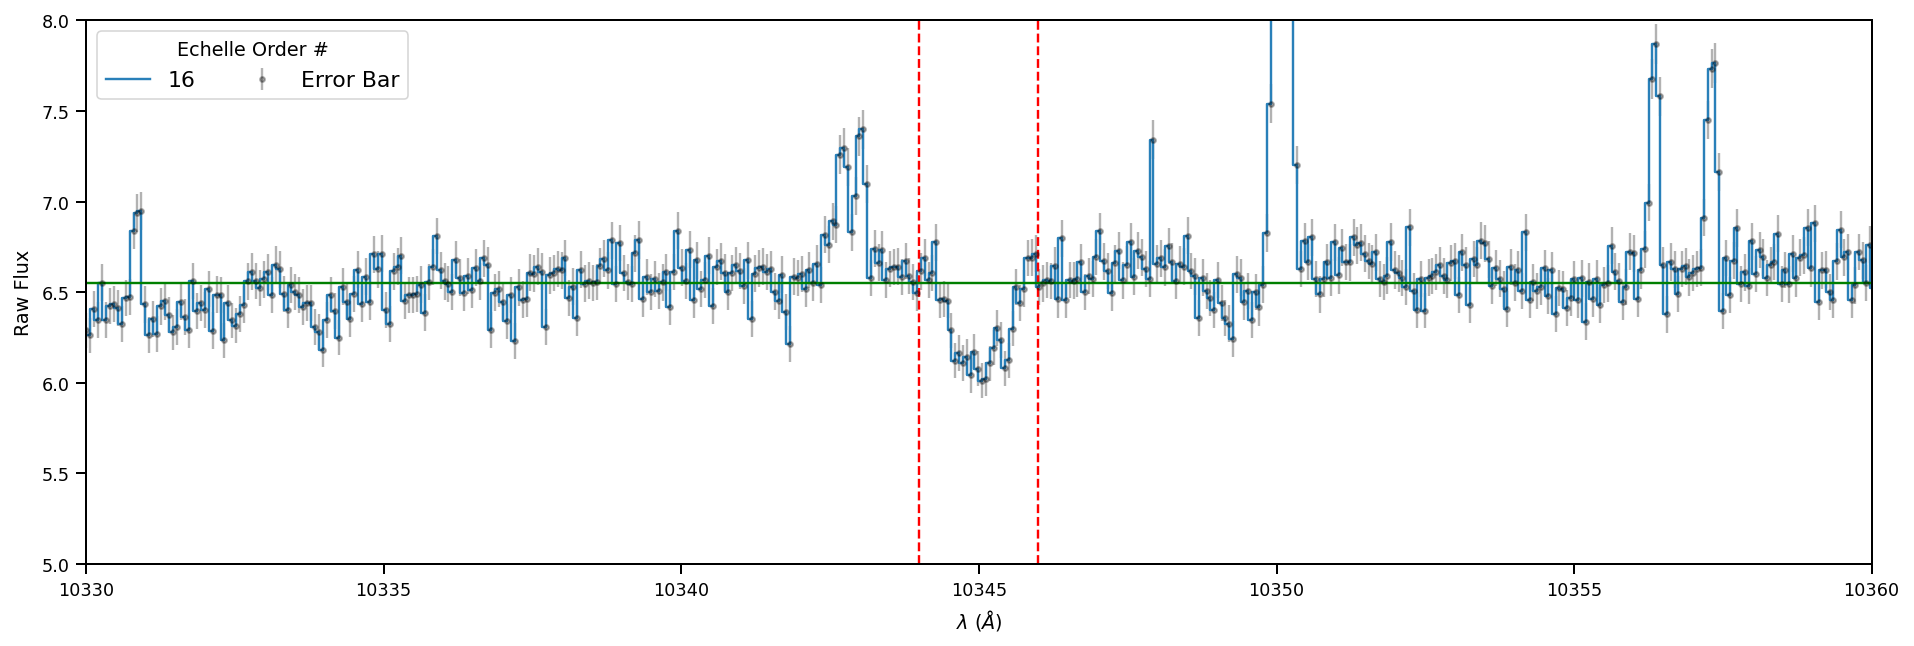

In [7]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(5,8)
plt.xlim(10330,10360)
wavelength1 = 10344
wavelength2 = 10346
continuum = 6.55
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian subtracted from it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b - A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.

$$f_\lambda(m, b, A, \mu, w)= 1 - \frac{A}{(m \mu + b)}\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

In [98]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10343.5) & (df['Sci Wavl'] < 10349)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [99]:
def generative_model(m, b, A, mu, logw, int_wl = 10330):
    """Generate the model given parameters"""
    continuum = m * (wl - int_wl) + b
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum - gaussian

Let's make an initial guess.

In [100]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.01, 6.4, 0.58, 10345, np.log(0.4)

In [101]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

(5.0, 8.0)

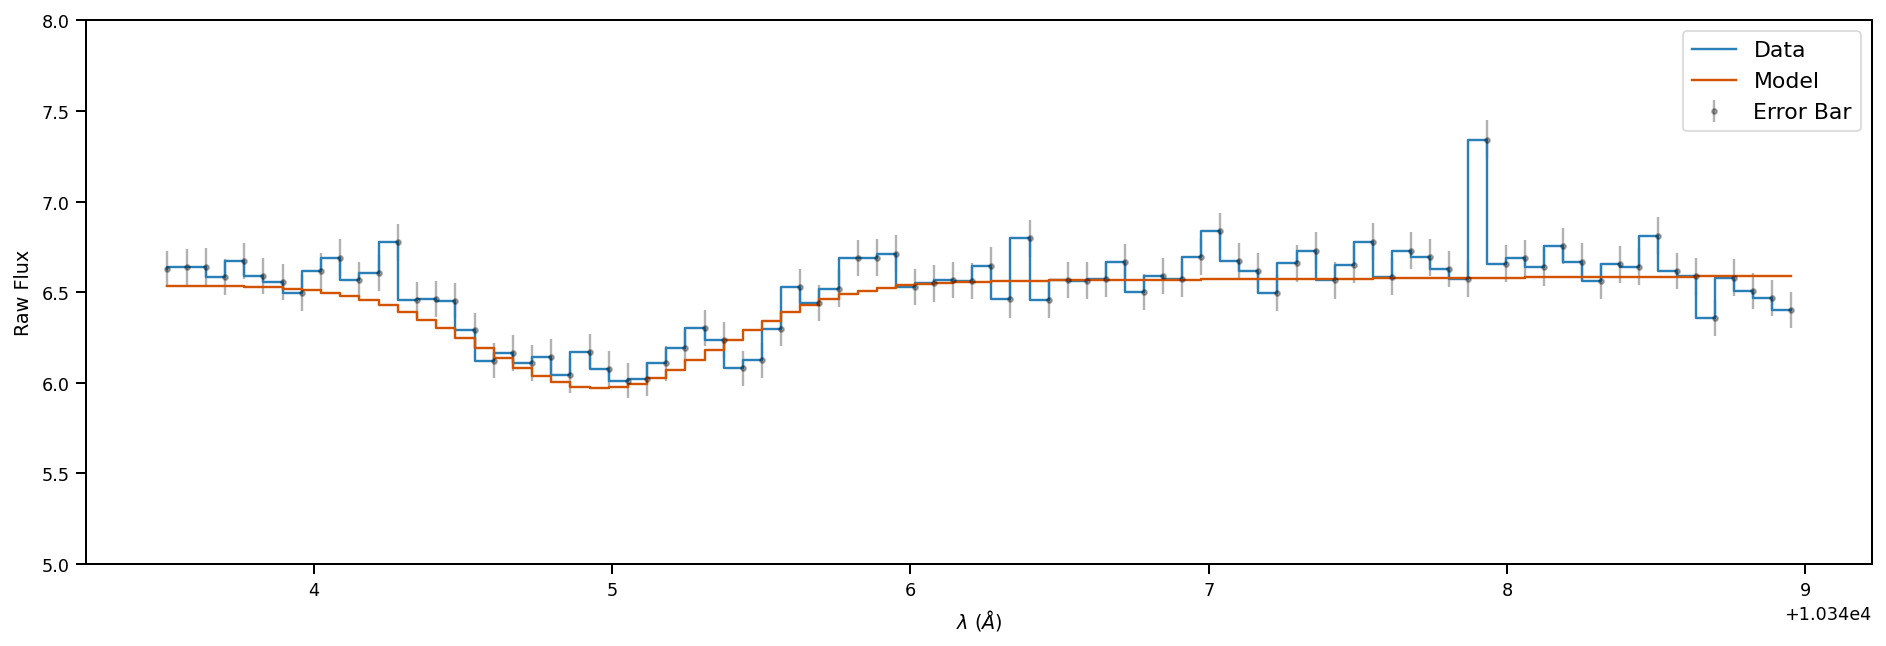

In [102]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
#plt.plot(wl, normalization);
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

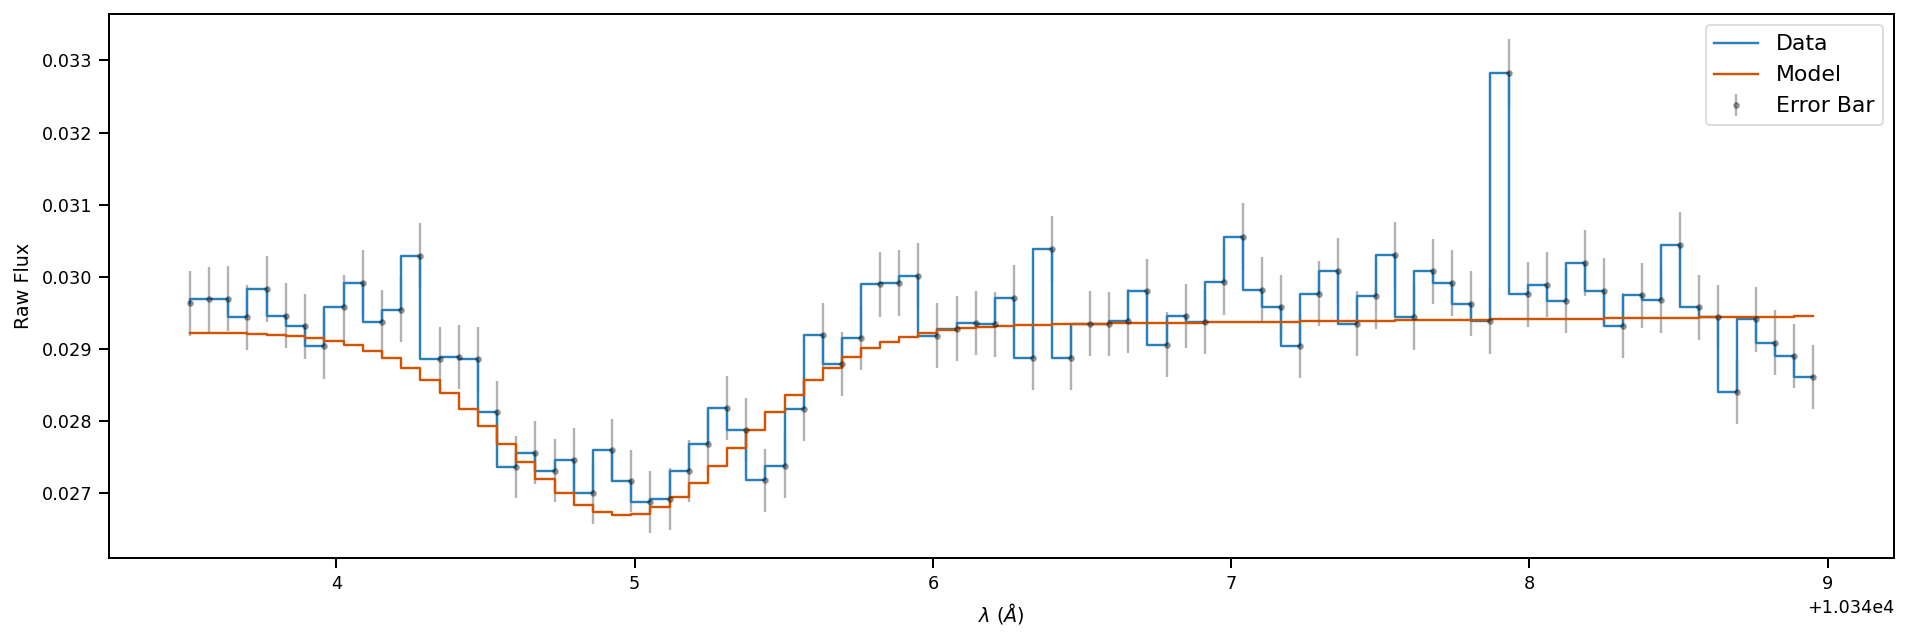

In [103]:
plt.figure(figsize=(16, 5))
normalization = (wl*0.021)+6.405
plt.step(wl, flux/normalization, label='Data', color='#2980b9');
plt.errorbar(wl, flux/normalization, unc/normalization, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess/normalization, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
#plt.ylim(0,0.1)


The guess is *close* but not perfect-- the line center is slightly off.  That's OK!  Let's use MCMC to fine tune these parameters, and tell us the uncertainty in the parameter values.  We will use [emcee](https://emcee.readthedocs.io/en/stable/).

In [104]:
import emcee

We need to compute the log likelihood of the data, which takes in the parameters and returns a scalar "quality of fit metric".  Here we use *chi squared*, the sum of the squares of the residuals, weighted by their uncertainties.

In [105]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = 10345)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [106]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

-261.38793148848845

In [107]:
n_walkers = 32
n_params = 5

In [108]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [109]:
n_steps = 5000

In [110]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 232.13it/s]


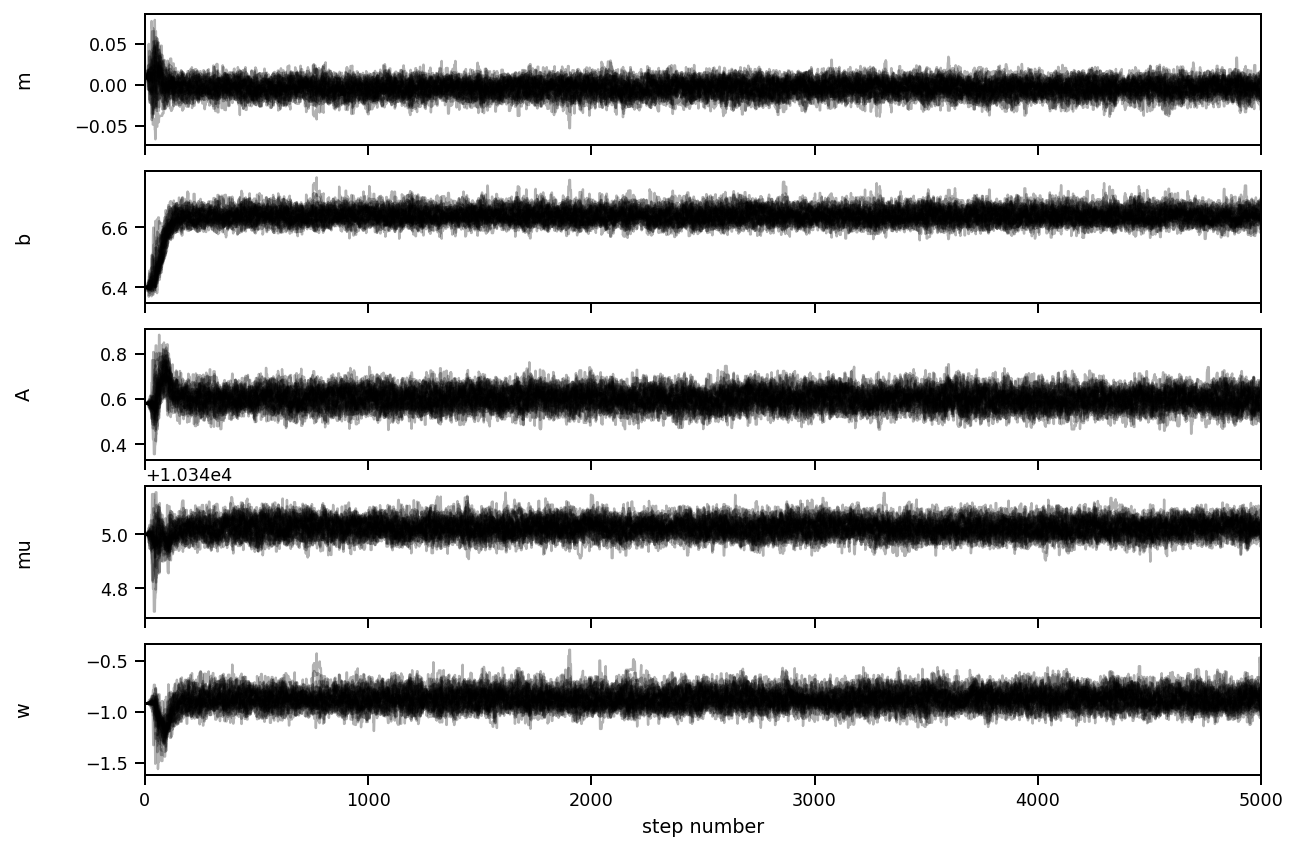

In [111]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [112]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 5)


In [113]:
ndim = 5

In [114]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [115]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = np.exp(samples[2000:, :, 4].reshape(-1))

Calculate the equivalent width from the MCMC samples.

In [116]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]

In [117]:
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit, int_wl = 10345)

(5.0, 8.0)

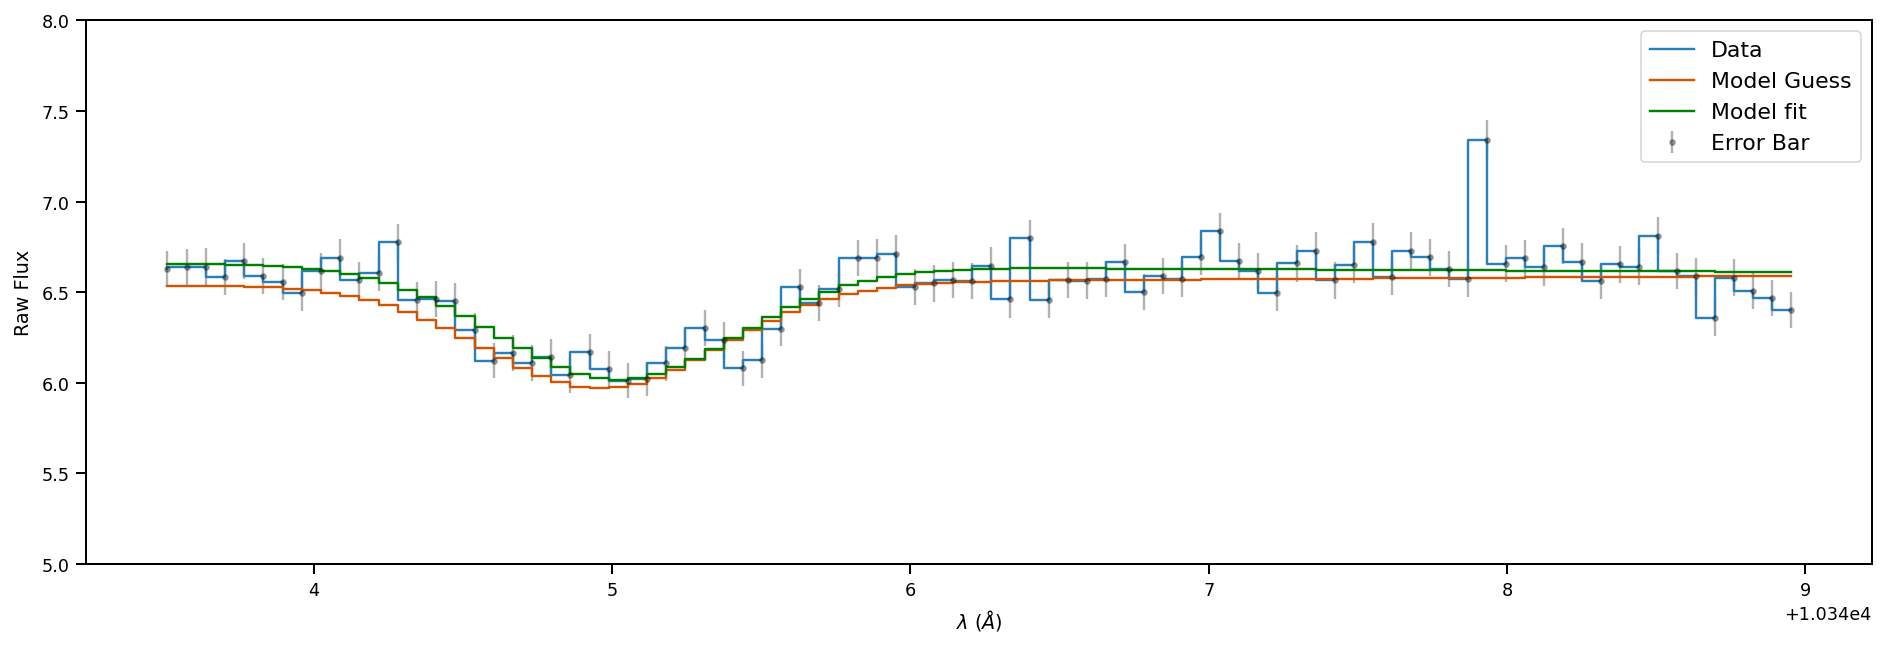

In [118]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

In [119]:
EW = ((2*np.pi)**.5)*(A_draws*w_draws)/(m_draws*(mu_draws-10345)+b_draws)
EW

array([0.0923546 , 0.08025853, 0.11045972, ..., 0.10822339, 0.10306073,
       0.09848977])

0.09506945588981357
0.00896586476068713


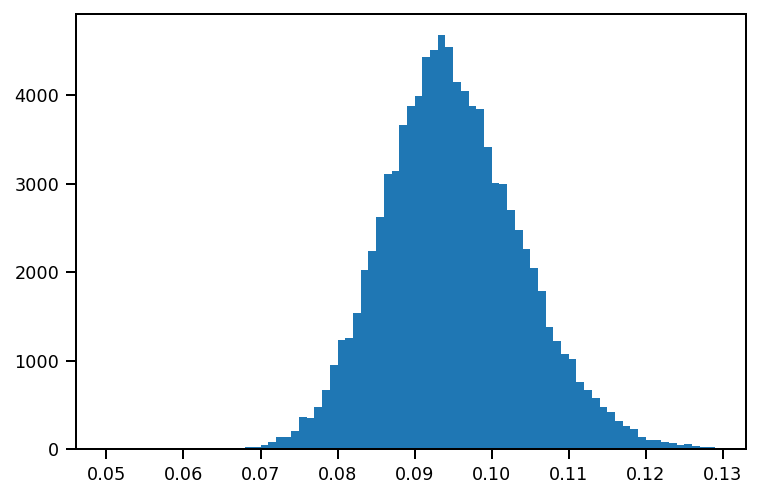

In [120]:
plt.hist(EW, bins = np.arange(0.05, 0.13, 0.001));
ew_mean = np.mean(EW)
ew_std = np.std(EW)
print(ew_mean)
print(ew_std)

0.5999892944834918
0.038556860197666236


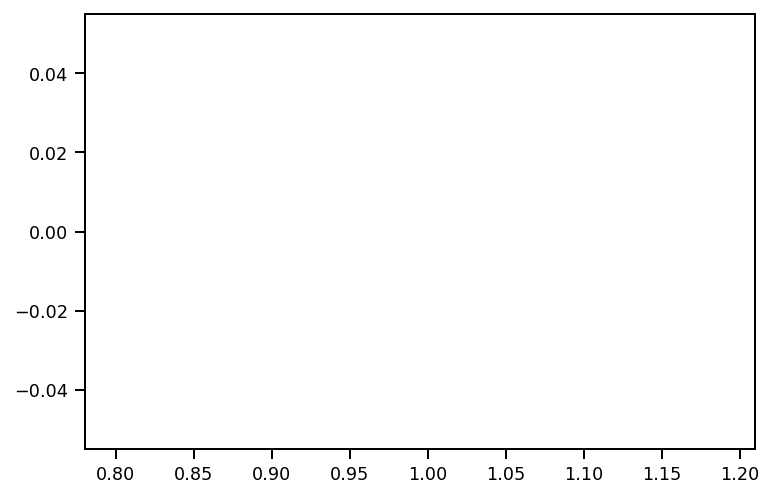

In [121]:
plt.hist(A_draws, bins = np.arange(0.8, 1.2, 0.01));
a_mean = np.mean(A_draws)
a_std = np.std(A_draws)
print(a_mean)
print(a_std)

6.639311709262007
0.022979664504147183


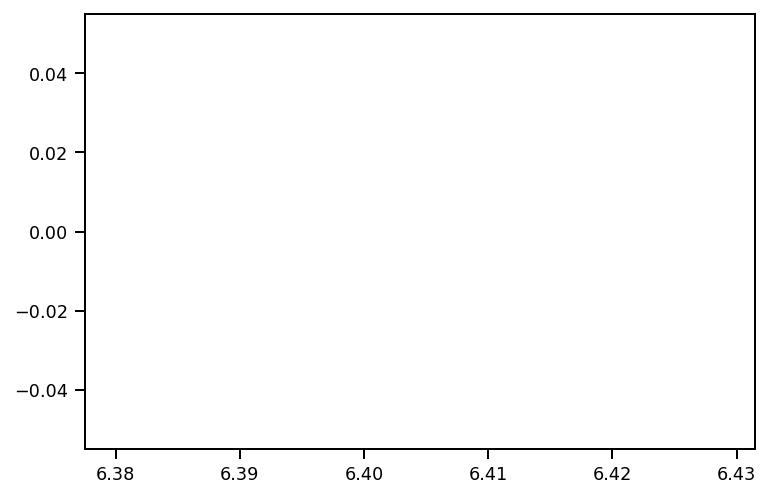

In [122]:
plt.hist(b_draws, bins = np.arange(6.38, 6.43, 0.001));
b_mean = np.mean(b_draws)
b_std = np.std(b_draws)
print(b_mean)
print(b_std)

-0.003483389037941914
0.008984037811012648


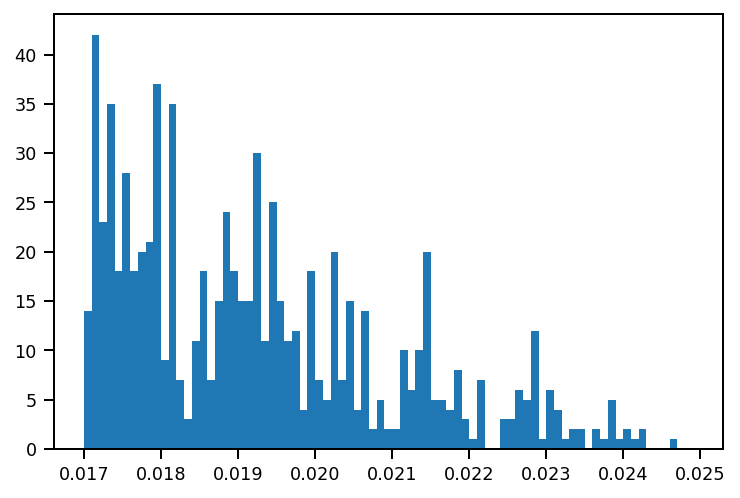

In [123]:
plt.hist(m_draws, bins = np.arange(0.017, 0.025, 0.0001));
m_mean = np.mean(m_draws)
m_std = np.std(m_draws)
print(m_mean)
print(m_std)

10345.02435904868
0.029095121356521016


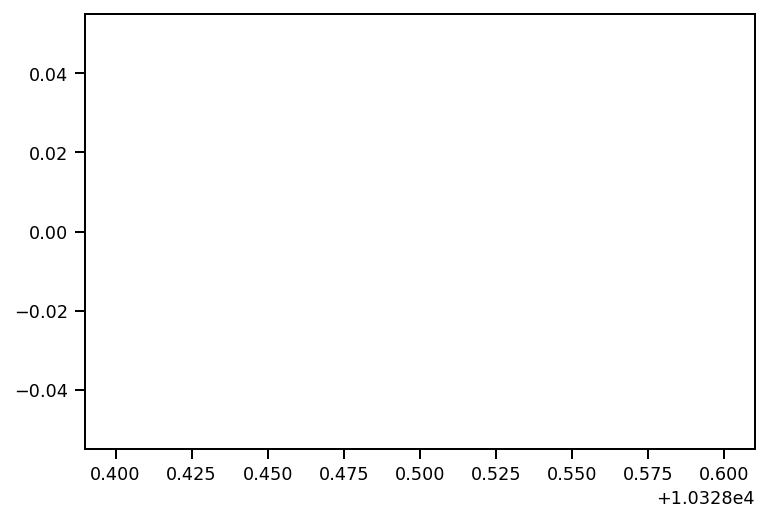

In [124]:
plt.hist(mu_draws, bins = np.arange(10328.4, 10328.6, 0.005));
mu_mean = np.mean(mu_draws)
mu_std = np.std(mu_draws)
print(mu_mean)
print(mu_std)

0.42011140349138487
0.03458525626926816


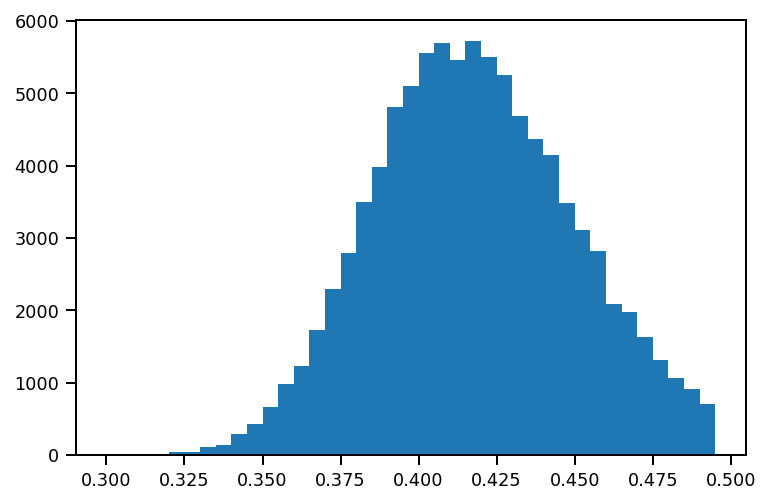

In [125]:
plt.hist(w_draws, bins = np.arange(0.3, 0.5, 0.005));
w_mean = np.mean(w_draws)
w_std = np.std(w_draws)
print(w_mean)
print(w_std)

In [126]:
means = [m_mean, b_mean, a_mean, mu_mean, w_mean]
means

[-0.003483389037941914,
 6.639311709262007,
 0.5999892944834918,
 10345.02435904868,
 0.42011140349138487]

In [127]:
index = 130 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [128]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 391 ms


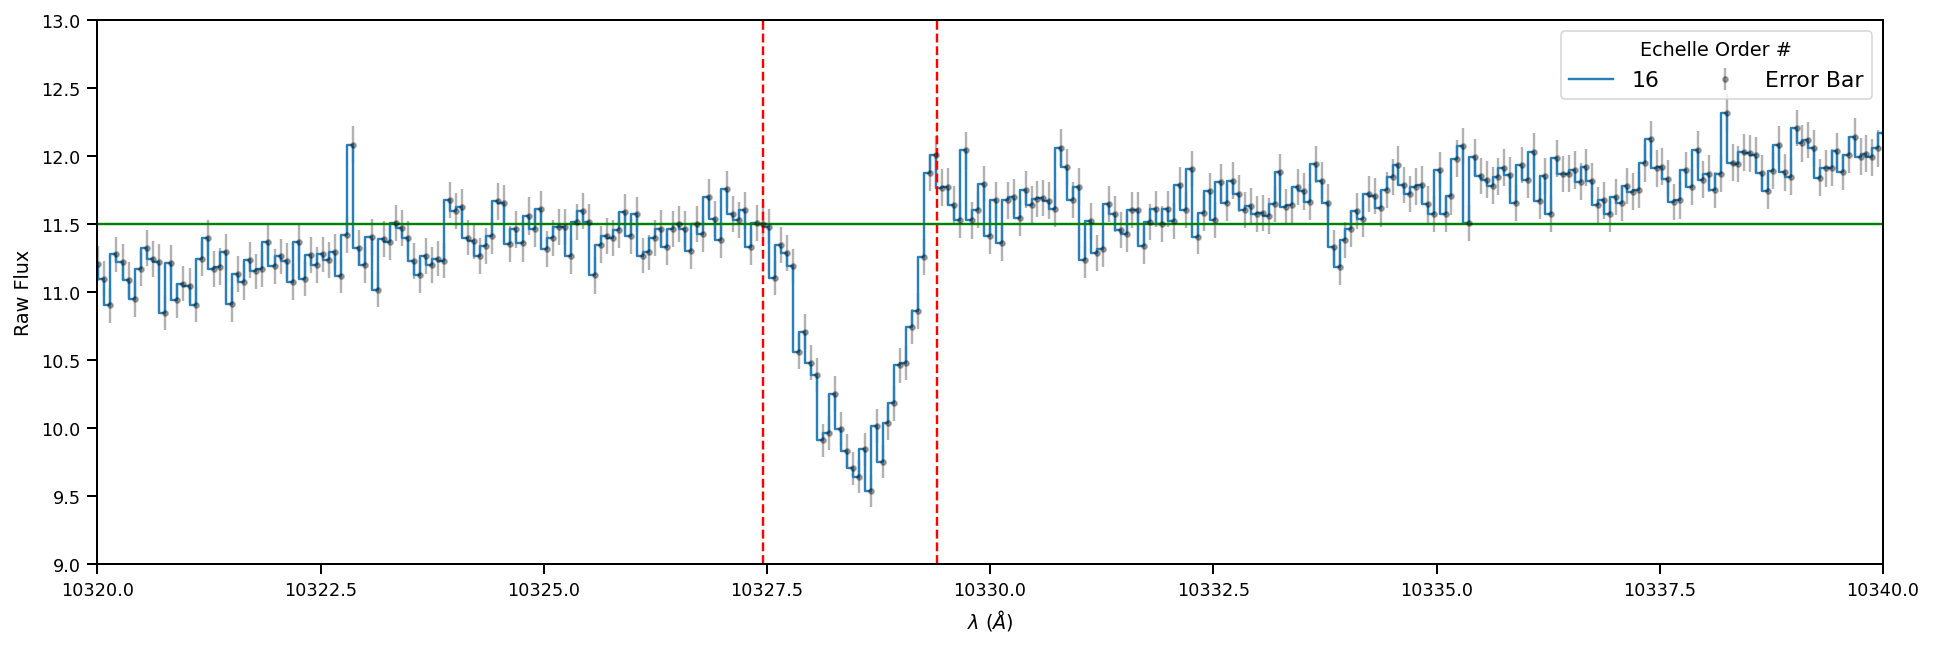

In [129]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(9,13)
plt.xlim(10320,10340)
wavelength1 = 10327.45
wavelength2 = 10329.4
continuum = 11.5
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

In [130]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10325) & (df['Sci Wavl'] < 10330)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [131]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.04, 11.5, 2, 10328.55, np.log(0.38)

In [132]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

(9.0, 12.5)

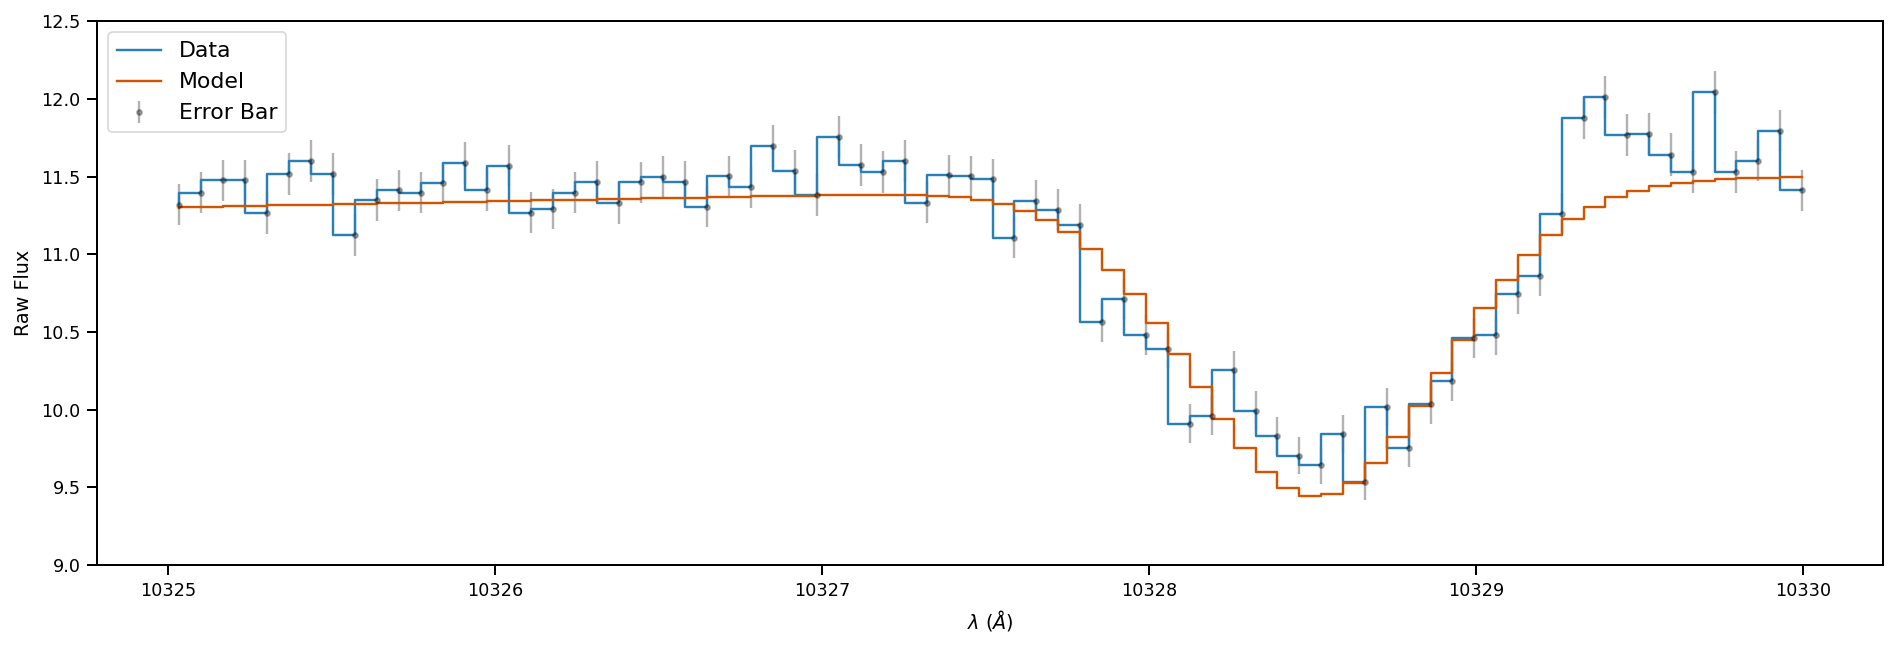

In [133]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(9,12.5)

In [134]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = 10328.5)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [135]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

-98.06367113092209

In [136]:
theta_guess

array([ 4.00000000e-02,  1.15000000e+01,  2.00000000e+00,  1.03285500e+04,
       -9.67584026e-01])

In [137]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

  5%|████                                                                          | 259/5000 [00:01<00:22, 212.95it/s]<ipython-input-99-0049102cbd09>:5: RuntimeWarning: divide by zero encountered in true_divide
  gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
<ipython-input-99-0049102cbd09>:5: RuntimeWarning: overflow encountered in true_divide
  gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
  6%|████▍                                                                         | 281/5000 [00:01<00:22, 213.97it/s]<ipython-input-99-0049102cbd09>:5: RuntimeWarning: overflow encountered in double_scalars
  gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
<ipython-input-99-0049102cbd09>:4: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 229.15it/s]


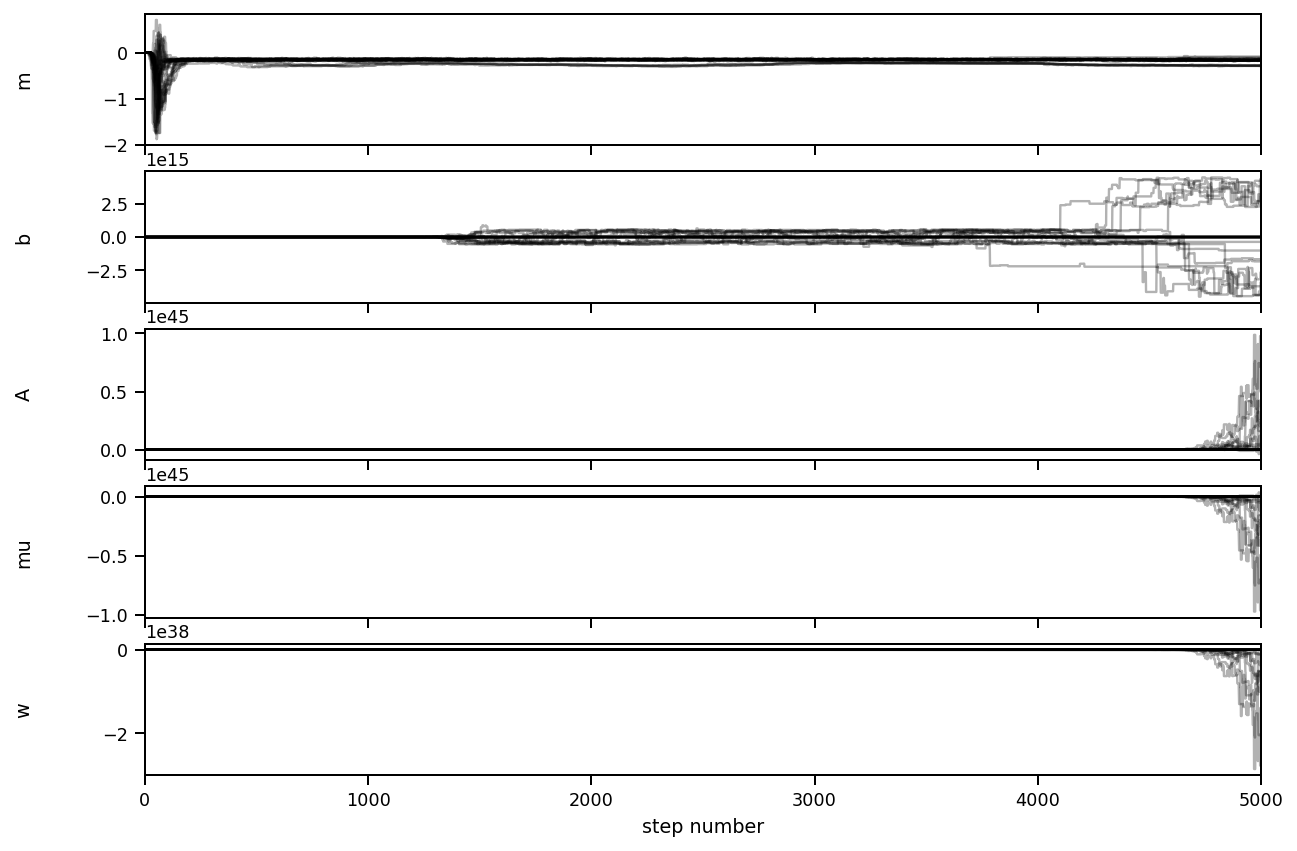

In [138]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [62]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>